In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

In [2]:
# Function to draw pitch saved in another file called support_functions.py
from support_functions import pitch, draw_pitch

# Load data

In [3]:
df = pd.read_json('data/figshare/match/matches_England.json')
df_events = pd.read_json('data/figshare/events/events_England.json')
df_teams = pd.read_json('data/figshare/teams.json')
df_players = pd.read_json('data/figshare/players.json')
df_player_rank = pd.read_json('data/figshare/playerank.json')
df_tags = pd.read_csv('data/figshare/tags2name.csv')

# Data Prep

In [4]:
# Work out the forward distance of each pass
def difference_in_x(row):
    if row['eventName'] == 'Pass':
        return row['positions'][1]['x'] - row['positions'][0]['x']
    else: 
        return 0
    
df_events['percent_x_gain']=df_events.apply(difference_in_x, axis=1)

# Work out the x position
def x_pos(row):
        return row['positions'][0]['x']

df_events['x']=df_events.apply(x_pos, axis=1)

# Extract position data
def position_extract(row):
    x  = row['positions'][0]['x']
    y  = row['positions'][0]['y']
    if row['eventName'] == 'Pass':
        dx = row['positions'][1]['x'] - row['positions'][0]['x']
        dy = row['positions'][1]['y'] - row['positions'][0]['y']
        return [x,y,dx,dy]       
    else: 
        # If it's not a pass set the distance to zero. (for now - need to think about free kicks etc)
        dx = 0
        dy = 0
        return [x,y,dx,dy]
    
df_events['position_data'] =df_events.apply(position_extract, axis=1)


In [5]:
# Expand the nested json data for players here
df_players = pd.concat([df_players, json_normalize(df_players['role'])], axis=1, sort=False)
df_players = df_players[['shortName','code3','wyId','birthDate','height','weight','foot']]

# Pull out the event tag ids into separate columns
df_events = df_events.join(pd.DataFrame(df_events.tags.values.tolist()))

# Rename the tag id columns. Each event has a variable number of tags depending what it is. 
df_events.rename(columns = {0:'tag_1',1:'tag_2',2:'tag_3',3:'tag_4',4:'tag_5',5:'tag_6'}, inplace=True)

# Create a dictionary of the tag to tag descriptions
area_dict = dict(zip(df_tags.Tag, df_tags.Description))

# For each tag convert from id to description
for col in ['tag_1','tag_2','tag_3','tag_4','tag_5']:
    df_events[col] = df_events[col].astype(str)
    df_events[col] = df_events[col].str.replace("{'id': ","").str.replace("}","")
    df_events[col] = df_events[col].replace('None', 'NaN').astype(float)
    df_events[col] = df_events[col].map(area_dict)
    df_events[col] = df_events[col].astype(str) 
    
#Create a column that concatenates the tag descriptions
df_events['tag_descriptions'] = df_events[['tag_1','tag_2','tag_3','tag_4','tag_5']].agg(','.join, axis=1)

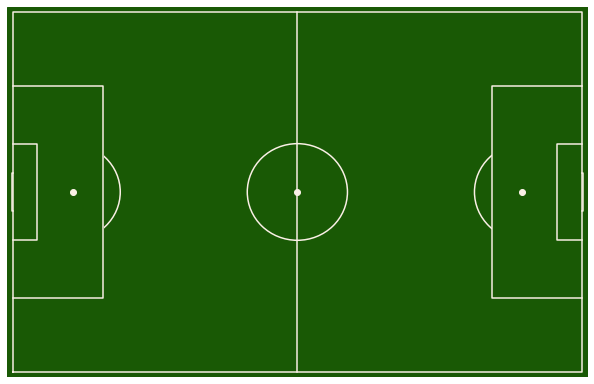

In [6]:
f = draw_pitch("#195905", "#faf0e6", "h", "full")

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24c325b6518>)

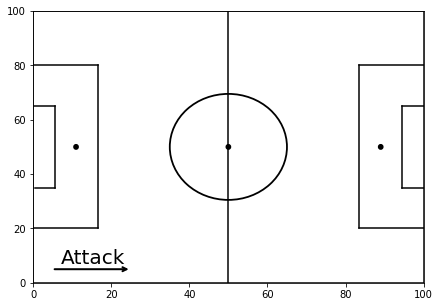

In [7]:
pitch()

# Explore One Season 

- Who gains the most net forward ground.


In [16]:
# Investigate which players on average make the most forward ground per pass durig the season
# Note the net - as passes going backwards are also included.

df_forward_gain = df_events[(df_events['eventName'] =='Pass')].groupby('playerId', as_index=False).agg({'percent_x_gain':'sum',
                                                                    'matchId':'count'}).sort_values('percent_x_gain',
                                                                                                    ascending=False)

df_forward_gain.rename(columns={'matchId':'number_events',
                               'percent_x_gain':'net_perc_x_gain'}, inplace=True)

# Number of accurate passes
df_pass_accurate = df_events[(df_events['eventName'] =='Pass') &
                            (df_events['tag_descriptions'].str.contains('Accurate'))].groupby('playerId', as_index=False).agg({'matchId':'count'})

df_pass_accurate.rename(columns={'matchId':'accurate_passes'}, inplace=True)

# Join with the player data to get their names
df_forward_gain= df_forward_gain.merge(df_players, how='left', left_on='playerId', right_on='wyId')
# Join the accurate pass data
df_forward_gain= df_forward_gain.merge(df_pass_accurate, how='left', left_on='playerId', right_on='playerId')

# Calculate the average percent gain per pass.
df_forward_gain['average_net_x_perc_gain_per_pass'] = df_forward_gain['net_perc_x_gain'] / df_forward_gain['number_events']
# Calculate the pass accuracy
df_forward_gain['pass_accuracy_perc'] = df_forward_gain['accurate_passes']/df_forward_gain['number_events']

# Goalkeepers would obviously dominate this so we exclude them and anyone that made less than a 1000 passes. 
# Could also chose just to look at midfields - as we have below. 
df_forward_gain[(df_forward_gain['code3'] == 'MID') &
                (df_forward_gain['number_events'] > 500)
               ].sort_values('average_net_x_perc_gain_per_pass',
                             ascending=False)[['shortName',
                                               'number_events',
                                               'average_net_x_perc_gain_per_pass','pass_accuracy_perc']].head(20)

,shortName,number_events,average_net_x_perc_gain_per_pass,pass_accuracy_perc
42,J. Shelvey,1267,10.018153,0.775059
81,C. Brunt,878,9.481777,0.768793
117,G. Barry,876,6.902968,0.800228
33,F\u00e0bregas,2024,6.712945,0.847332
103,D. Fletcher,1005,6.678607,0.816915
153,Mikel Merino,744,6.598118,0.817204
89,L. Cook,1184,6.497466,0.828547
85,Y. Cabaye,1250,6.436800,0.840000
61,L. Milivojevi\u0107,1559,6.409237,0.835792
113,D. Gosling,979,6.353422,0.808989


Interestingly Shelvey is the highest rated midfield player. 

Distance per pass is important but so is pass accuracy. Where's the best balance between taking risks to get further up the field but keeping the ball?

Is there anyway to tell this. Look at how pass percentage and winning relate. But this doesn't really answer that question.  


In [54]:
# Forward ground made per pass but scaling for the position on the pitch.
# what about ignoring backwards passes???
# Convert x into a log scale. 

# Explore One Match 

- Liverpool v Brighton
- May 13th 2018

In [9]:
def draw_arrows(row):
    plt.arrow(row['position_data'][0],row['position_data'][1], row['position_data'][2], row['position_data'][3],width=0.5)
    return

In [10]:
class Match():
    
    '''
    A class to store a single match. 
    Intention is to make it a little easier to navigate analysing one match.
    
    inputs
    - the match id in question
    - all original datasets
    - extracts only the data relating to this specific match. 
    '''
    
    def __init__(self, match_id, df_matches, df_events, df_teams,df_players, df_player_rank):
        self.match_id = match_id
        self.match = df_matches[df_matches['wyId'] == match_id].reset_index()
        self.events = df_events[df_events['matchId'] == match_id].reset_index()
        self.player_rank = df_player_rank[df_player_rank['matchId'] == match_id].reset_index()
        print('Number of events in this match is {}'.format(len(self.events)))
        
        # Easiest to use the label (names of teams) to get home and away team
        self.home_team = self.match['label'][0].split(',')[0].split(' - ')[0] 
        self.away_team = self.match['label'][0].split(',')[0].split(' - ')[1] 
        
        self.homeid = df_teams[df_teams['name'] ==self.home_team]['wyId'].reset_index()['wyId'][0]
        self.awayid = df_teams[df_teams['name'] ==self.away_team]['wyId'].reset_index()['wyId'][0]
        
        self.team_data = json_normalize(self.match['teamsData'][0])
        
        # Create lineups for each team
        self.home_lineup = json_normalize(self.team_data[str(self.homeid) + '.formation.lineup'][0])
        self.away_lineup = json_normalize(self.team_data[str(self.awayid) + '.formation.lineup'][0])
        
        # Join with the player data so we have their names and characteristics.
        self.home_lineup = self.home_lineup .merge(df_players, how='left', left_on='playerId', right_on='wyId')
        self.away_lineup = self.away_lineup.merge(df_players, how='left', left_on='playerId', right_on='wyId')
        
        # Join with the player rank data so we have their exact position and their rank
        self.home_lineup = self.home_lineup.merge(self.player_rank, how='left', left_on='playerId', right_on='playerId')
        self.away_lineup = self.away_lineup.merge(self.player_rank, how='left', left_on='playerId', right_on='playerId')
        
        # Calculate the net % distance made up the pitch
        grouped_forward_distance = self.events.groupby('playerId', as_index=False).agg({'percent_x_gain':'sum'})
        self.home_lineup = self.home_lineup.merge(grouped_forward_distance, how='left', left_on ='playerId', right_on='playerId')
        self.away_lineup = self.away_lineup.merge(grouped_forward_distance, how='left', left_on ='playerId', right_on='playerId')
    
    def arrow_pass_map_player(self, playerId):
        pitch()
        self.events[(self.events['playerId'] == playerId) & (self.events['eventName'] == 'Pass') ].apply(draw_arrows, axis=1)
        plt.show()
        
    def net_positive_ground(self):
        # Compare the net positive ground made (passes only)
        plt.bar(self.home_lineup['shortName'], self.home_lineup['percent_x_gain'])
        plt.xticks(rotation=90)
        plt.xlabel('player')
        plt.ylabel('net % pitch gain')
        plt.show()
        
        # away team
        plt.bar(self.away_lineup['shortName'], self.away_lineup['percent_x_gain'])
        plt.xticks(rotation=90)
        plt.xlabel('player')
        plt.ylabel('net % pitch gain')
        plt.show()

    def display_keeper_distribution(self):
        # Compare the tactics of the two keepers
        keepers = []
        keepers_names = []
        keepers.append(self.home_lineup[self.home_lineup['code3'] == 'GKP'].reset_index()['playerId'][0])
        keepers.append(self.away_lineup[self.away_lineup['code3'] == 'GKP'].reset_index()['playerId'][0])
        self.arrow_pass_map_player(keepers[0])
        self.arrow_pass_map_player(keepers[1])

     

In [11]:
example_game = Match(2500092, df, df_events, df_teams, df_players,df_player_rank)

Number of events in this match is 1703


In [12]:
example_game.away_lineup

,goals,ownGoals,playerId,redCards,yellowCards,shortName,code3,wyId,birthDate,height,weight,foot,index,goalScored,matchId,minutesPlayed,playerankScore,roleCluster,percent_x_gain
0,0,2,120,0,0,J. Locadia,FWD,120,1993-11-07,185,78,right,1387.0,0.0,2500092.0,57.0,-0.0077,central MF,8
1,0,2,61961,0,0,B. Kayal,MID,61961,1988-05-02,178,74,right,39049.0,0.0,2500092.0,57.0,0.0016,central MF,-23
2,0,2,8242,0,0,S. Duffy,DEF,8242,1992-01-01,193,76,right,42938.0,0.0,2500092.0,71.0,0.0148,right CB,82
3,null,0,61390,0,0,M. Ryan,GKP,61390,1992-04-08,184,82,right,NaN,NaN,NaN,NaN,NaN,NaN,761
4,null,0,9097,0,0,L. Dunk,DEF,9097,1991-11-21,192,88,right,45649.0,0.0,2500092.0,90.0,0.0118,left CB,225
5,null,0,8086,0,0,D. Stephens,MID,8086,1989-12-12,185,71,right,42481.0,0.0,2500092.0,90.0,0.0002,right CB,287
6,null,0,26495,0,0,G. Bong,DEF,26495,1988-04-25,187,74,left,22363.0,0.0,2500092.0,90.0,-0.0024,left CB,362
7,null,0,25950,0,0,A. Knockaert,MID,25950,1991-11-20,172,69,left,20803.0,0.0,2500092.0,90.0,0.0035,right MF,-17
8,null,0,247248,0,0,S. March,MID,247248,1994-07-20,180,72,left,17000.0,0.0,2500092.0,90.0,0.0159,left FW,131
9,null,0,466,0,0,D. Pr\u00f6pper,MID,466,1991-09-02,185,72,right,37072.0,0.0,2500092.0,90.0,-0.0053,left CB,251


In [13]:
example_game.home_lineup

,goals,ownGoals,playerId,redCards,yellowCards,shortName,code3,wyId,birthDate,height,weight,foot,index,goalScored,matchId,minutesPlayed,playerankScore,roleCluster,percent_x_gain
0,0,2,25747,0,0,S. Man\u00e9,FWD,25747,1992-04-10,175,75,right,19574.0,0.0,2500092.0,74.0,0.0197,left FW,-54
1,0,2,15808,0,0,Roberto Firmino,FWD,15808,1991-10-02,181,76,right,7338.0,0.0,2500092.0,84.0,0.0265,central FW,161
2,1,2,120353,0,0,Mohamed Salah,FWD,120353,1992-06-15,175,72,left,1450.0,1.0,2500092.0,84.0,0.0993,right FW,-34
3,1,2,25393,0,0,D. Lovren,DEF,25393,1989-07-05,188,84,right,17411.0,1.0,2500092.0,90.0,0.0236,right CB,558
4,1,2,286831,0,0,D. Solanke,FWD,286831,1997-09-14,185,80,right,25342.0,1.0,2500092.0,90.0,0.0708,central FW,10
5,null,0,346101,0,0,T. Alexander-Arnold,DEF,346101,1998-10-07,175,69,right,30182.0,0.0,2500092.0,90.0,-0.0207,right FW,244
6,1,2,222220,0,0,A. Robertson,DEF,222220,1994-03-11,178,63,left,14337.0,1.0,2500092.0,90.0,0.0558,left MF,89
7,null,0,116,0,0,G. Wijnaldum,MID,116,1990-11-11,175,74,right,1107.0,0.0,2500092.0,90.0,0.0249,central MF,147
8,null,0,7964,0,0,J. Henderson,MID,7964,1990-06-17,182,67,right,42107.0,0.0,2500092.0,90.0,0.0058,central MF,659
9,null,0,15175,0,0,L. Karius,GKP,15175,1993-06-22,190,87,right,NaN,NaN,NaN,NaN,NaN,NaN,433


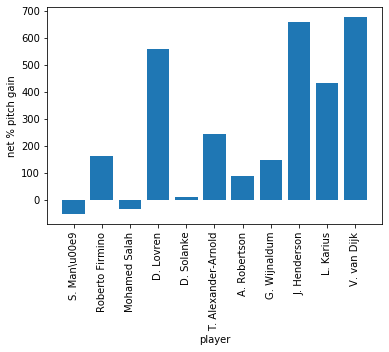

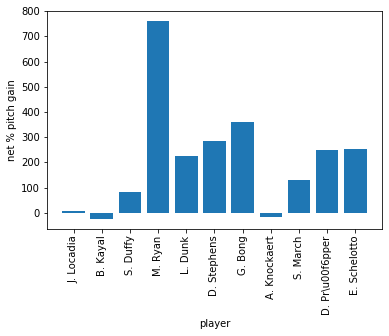

In [14]:
example_game.net_positive_ground()

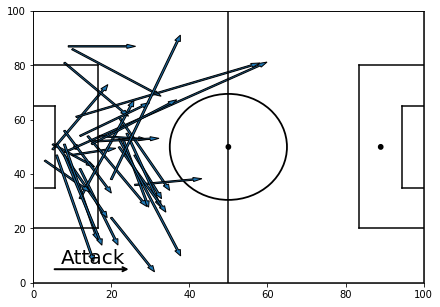

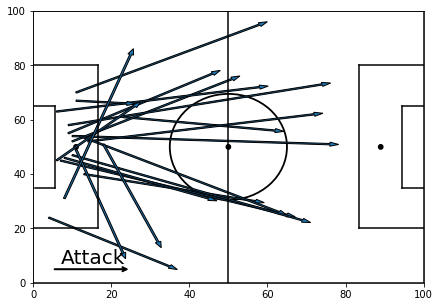

In [15]:
example_game.display_keeper_distribution()